<a href="https://colab.research.google.com/github/hlapin/DHTeaching/blob/master/Getting_Started_With_Text_Mining_Stylometry%2C_TF_IDF%2C_Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This colab notebook was prepared for teaching purposes for a session on text mining in a course on digital tools in historical research.  
For data, the examples use the text of the *Federalist Papers*.   
Much of what follows is derivative of resources available on the web, although I have revised material for display or pedagogical purposes. In particular I have made use of the tutorial on stylometry at _The Programing Historian_:
> https://programminghistorian.org/en/lessons/introduction-to-stylometry-with-python   

(The goal has been to provide "plug-and-play" demonstrations, leaving space and time open for discussion of methods and concepts.)
For those of you new to Colab/Jupyter, there are text blocks, code blocks, and--after running code--output blocks. Subsections may be hidden by default, but `ctrl+[` should expand all sections and `ctrl+]` collapse them.    
You should not need to write any code (although you are welcome to experiment!): just click the run (play arrow) button at the top left of each code block. You generally ***do*** need to run the code blocks in order.  

# Getting the text
We are going to be working with the Federalist Papers  
We need to:
1. Download a zip file from github (Programming Historian repository)
2. Unzip it and
3. Unpack the files in a local [to Colab] folder


In [ ]:
import requests, io, zipfile, os
os.chdir ('/content/') # changes working directory on local machine
r = requests.get('https://github.com/programminghistorian/ph-submissions/blob/gh-pages/assets/introduction-to-stylometry-with-python/stylometry-federalist.zip?raw=true')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()



There is now a local file on the virtual machine you are using called `data` with the downloaded files.   
You can check that in the files tools in the left hand panel:    
> 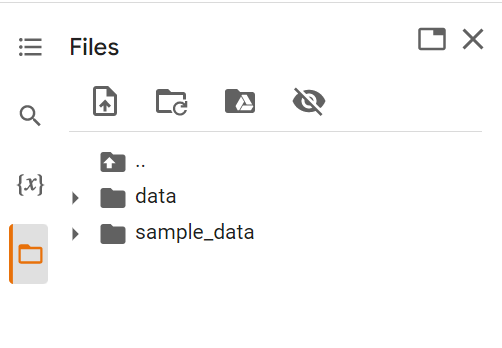    

However, let's set the working directory to that directory and list its contents programmatically.


In [ ]:
os.chdir('/content/data/')
os.listdir()

['federalist_25.txt',
 'federalist_21.txt',
 'federalist_57.txt',
 'federalist_27.txt',
 'federalist_78.txt',
 'federalist_19.txt',
 'federalist_48.txt',
 'federalist_7.txt',
 'federalist_6.txt',
 'federalist_4.txt',
 'federalist_83.txt',
 'federalist_53.txt',
 'federalist_76.txt',
 'federalist_16.txt',
 'federalist_74.txt',
 'federalist_8.txt',
 'federalist_85.txt',
 'federalist_81.txt',
 'federalist_38.txt',
 'federalist_46.txt',
 'federalist_50.txt',
 'federalist_39.txt',
 'federalist_47.txt',
 'federalist_36.txt',
 'federalist_2.txt',
 'federalist_80.txt',
 'federalist_15.txt',
 'federalist_61.txt',
 'federalist_63.txt',
 'federalist_20.txt',
 'federalist_68.txt',
 'federalist_37.txt',
 'federalist_52.txt',
 'federalist_72.txt',
 'federalist_67.txt',
 'federalist_54.txt',
 'federalist_17.txt',
 'federalist_42.txt',
 'federalist_34.txt',
 'federalist_26.txt',
 'federalist_65.txt',
 'federalist_31.txt',
 'federalist_41.txt',
 'federalist_5.txt',
 'federalist_1.txt',
 'federalist_24.t

## Text to Dataframe
Now we are going to read each of the individual chapters into a table (a pandas dataframe, `dfPapers`) where each row is a document and that has the column headings `file_name` and `text`.

For later use we are going to create a column `num` that has only the numerical part of the paper's name (`8` for `Federalist_8`) and we are going to extract an approximation of the document's title (the third line in each document; that will go into the column `title`).

In [ ]:
import pandas as pd # pandas is a data structure library
import glob         # finds all pathnames matching a specific pattern


# create an dataframe with each document as a row
# we start by creating a "dictionary" to represent the columns
results = {"file_name":[],"num":[],"title":[],"text":[]}

for item in glob.glob('*[0-9].txt'):  # read only files with names ending
                                      # with numerals.Why?

   # each `item` is a path that matches the pattern, e.g., 'Federalist_8.txt'

   # below, the function split() splits a string into substrings based on
   # a specified separator.
   # [In Python, the first item in a list is indexed as 0 rather than 1]

   short = item.split('.')[0]           # grab filename without '.txt'
   paperNum = int(short.split('_')[1])  # grab the numeral after '_'
   with open(item, "r") as file_open:
     txt = file_open.read()
     results["file_name"].append(short)
     results["num"].append(paperNum)
     results["title"].append(txt.split('\n')[2])
     results["text"].append(txt.replace('\n', ' '))

# pandas has built in abilities to convert dictionaries to dataframes
dfPapers = pd.DataFrame(results)
dfPapers = dfPapers.sort_values(["num"])
dfPapers = dfPapers.reset_index(drop=True)

#let's check that we got the documents into shape
dfPapers

,file_name,num,title,text
0,federalist_1,1,General Introduction,1 General Introduction For the Independent ...
1,federalist_2,2,Concerning Dangers from Foreign Force and Infl...,2 Concerning Dangers from Foreign Force and ...
2,federalist_3,3,The Same Subject Continued (Concerning Dangers...,3 The Same Subject Continued (Concerning Dan...
3,federalist_4,4,The Same Subject Continued (Concerning Dangers...,4 The Same Subject Continued (Concerning Dan...
4,federalist_5,5,The Same Subject Continued (Concerning Dangers...,5 The Same Subject Continued (Concerning Dan...
...,...,...,...,...
80,federalist_81,81,"The Judiciary Continued, and the Distribution ...","81 The Judiciary Continued, and the Distribu..."
81,federalist_82,82,The Judiciary Continued.,82 The Judiciary Continued. From McLEAN's E...
82,federalist_83,83,The Judiciary Continued in Relation to Trial b...,83 The Judiciary Continued in Relation to Tr...
83,federalist_84,84,Certain General and Miscellaneous Objections t...,84 Certain General and Miscellaneous Objecti...


## A Bit of Cleanup
Let's remove punctuation and convert all upper case to lower case, and then print a sample of our data to if we got it right.  
> *Regular expressions* (often `regex`) refers to a set of operations on text that can be defined by patterns (a valid email address is an unbroken string, followed by '@' followed by a domain and one of a number of valid suffixes (.org, .edu, .ac.uk). For an example of how complex the regex may be to capture "all" emails see: https://regex101.com/library/8pGQaK




In [ ]:
import re #re is the module that does regular expression operations

# note that pandas allows us to operate on all the cells in a column
# of a dataframe by filtering by column label: dfPapers['text']

# regularize spacing:
# replace one or more line breaks or spaces with single space
dfPapers['text'] = dfPapers['text'].map(lambda x:
                                    re.sub(r"\s+", ' ', x))

# remove punctuation, numerals, etc. This time replace with no space
dfPapers['text'] = dfPapers['text'].map(lambda x:
                                    re.sub(r"[\d\'\"\(\)\:;,\.!?‘’“”]", '', x))

# convert characters to lower case
dfPapers['text'] = dfPapers['text'].map(lambda x: x.lower())

# again, let's check that we got the documents into proper shape
dfPapers

,file_name,num,title,text
0,federalist_1,1,General Introduction,general introduction for the independent jou...
1,federalist_2,2,Concerning Dangers from Foreign Force and Infl...,concerning dangers from foreign force and in...
2,federalist_3,3,The Same Subject Continued (Concerning Dangers...,the same subject continued concerning danger...
3,federalist_4,4,The Same Subject Continued (Concerning Dangers...,the same subject continued concerning danger...
4,federalist_5,5,The Same Subject Continued (Concerning Dangers...,the same subject continued concerning danger...
...,...,...,...,...
80,federalist_81,81,"The Judiciary Continued, and the Distribution ...",the judiciary continued and the distribution...
81,federalist_82,82,The Judiciary Continued.,the judiciary continued from mcleans edition...
82,federalist_83,83,The Judiciary Continued in Relation to Trial b...,the judiciary continued in relation to trial...
83,federalist_84,84,Certain General and Miscellaneous Objections t...,certain general and miscellaneous objections...


# Some Exploratory Analysis
First we are going to do some exploratory text analysis by making a word cloud.  
How does the model select words to present?

## Frequency vs significance
In a word cloud, frequency determines the size of the word, but:
* Is it really modelling the ***most frequent*** words?
* What is the problem with words like may, will?

The python library that does the work for us has a default set of `stopwords`: very common words that it filters out.

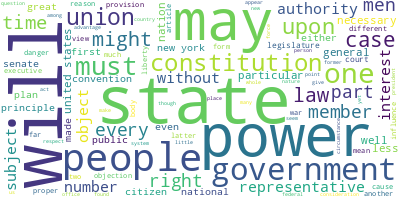

In [ ]:
from wordcloud import WordCloud

# code adapted from https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
# See also: https://towardsdatascience.com/generate-meaningful-word-clouds-in-python-5b85f5668eeb

# Join the different processed titles together into one long text.
long_string = ','.join(list(dfPapers['text'].values))

# Create a WordCloud object
# You can change the parameters below
wordcloud = WordCloud(background_color="white",
                        max_words=100,
                        contour_width=3,
                        contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()


## Let's run the same program without any stopwords

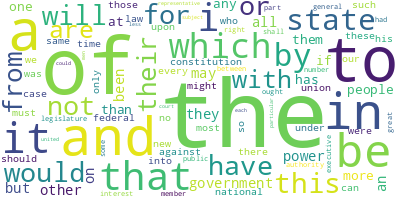

In [ ]:
stopwords = set() # define the list of stopwords as an empty set

# Join the different processed papers together into one long text.
long_string = ','.join(list(dfPapers['text'].values))

# Create a WordCloud object
# You can change the parameters below
wordcloud = WordCloud(background_color="white",
                        max_words=100,
                        contour_width=3,
                        stopwords = stopwords,
                        collocations=False, #only single tokens
                        contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

# Stylometry
The approach we are taking to stylometry is based on most frequent ("function") words. We could refine this further, but the basic observation is that no two authors use very common words (in English) like "the" or "and" or "of" identically (or punctuate quite the same way). In principle, we should be able to create a "fingerprint" for a given author based on the distinctive use of these stopwords.
From there techniques can become quite complicated, but the basic idea is that is that if we take a number of features (in our case, most frequent words) and see how these are used by each author, we can use this to measure distance between sample texts or authors' corpora. Before we do that we want to standardize our measurements (so that a larger corpus does not outweigh a smaller one) and decide on how to weight the features. (If the word "the" is about 10% of all the words it is clearly potentially distinctive; but how much should it count against the next most frequent words?)

# Stylometry I Burrow's Delta and Author Identification
> Adapted from "Programming Historian"   
https://doi.org/10.46430/phen0078   

This section uses the same texts as before (The Federalist Papers) to illustrate the use of **Burrows's Delta**. What this tries to do is to measure how each writer in a corpus uses "function words" (in English, the very common words like "the" and "is" and "to"; precisely the kinds of words that for other purposes would be classed as "stopwords").       
`Delta` seeks to aggregate the observations about each of the features we are testing for (we are using the 30 most common words in the document set).  
For each of the features we compare the frequency of the word in each of the texts we are examining in comparison with that of the corpus as a whole, and standardize the measurements across the corpus (so that more prolific authors [Hamilton] or more common words do not outweigh all the other authors or features).   
We also hold out Federalist 64 as a test case, and calculate `Delta` between that essay, and the other authors. A smaller `Delta` between texts means that two texts are "closer" to each other.

## First let's modify the dataframe we created to add attribution
Follows the canonical division plus test case as in PH

In [ ]:
# A "canonical" division into authors plus one test case, as in PH
papers = {
    'Madison': [10, 14, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
    'Hamilton': [1, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 21, 22, 23, 24,
                 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 59, 60,
                 61, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
                 78, 79, 80, 81, 82, 83, 84, 85],
    'Jay': [2, 3, 4, 5],
    'Shared': [18, 19, 20],
    'Disputed': [49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 62, 63],
    'TestCase': [64]
}
k, v = list(papers.keys()), list(papers.values())
def return_attrib (num):
  """ checks for the document no in lists of values
      returns first letter of attribution
      to use as label. """
  for i in v:
    if num in i:
      return k[v.index(i)][0]

# insert attribution to datatable in first position if it does not exist
# if not "attrib" in dfPapers.columns:
#   dfPapers.insert(loc=0, column='attrib',value='')


dfPapers["attrib"] = dfPapers["num"].apply(return_attrib)
dfPapers.head(5)


,file_name,num,title,text,attrib
0,federalist_1,1,General Introduction,general introduction for the independent jou...,H
1,federalist_2,2,Concerning Dangers from Foreign Force and Infl...,concerning dangers from foreign force and in...,J
2,federalist_3,3,The Same Subject Continued (Concerning Dangers...,the same subject continued concerning danger...,J
3,federalist_4,4,The Same Subject Continued (Concerning Dangers...,the same subject continued concerning danger...,J
4,federalist_5,5,The Same Subject Continued (Concerning Dangers...,the same subject continued concerning danger...,J


## Feature Selection
We are choosing 30 as in PH example.

Create a composite feature set for all texts (except test case). We will be using the `nltk` (Natural Language Toolkit) to do some of the calculating for us.

In [ ]:
import nltk

# filter dataframe to exclude testcase
# this is a variation of the operation we used above for the word cloud
# create a single string of all the documents EXCLUDING the test case
corpus = ' '.join(dfPapers["text"][dfPapers["attrib"] != "T"].values)

# separate into a list of individual words ('tokens').
# These are our 'features'
corpus_tokens = corpus.split()

# create frequency list using built in nltk library `FreqDist`
# this will give us the n (30) most common words and how often they appear
# across our corpus
whole_corpus_freq_dist = list(nltk.FreqDist(corpus_tokens).most_common(30))

# # uncomment and run again to see the first 10
# print(whole_corpus_freq_dist[ :10 ])

# tabular data structure to contain our statistical information
dfFeatures = pd.DataFrame( columns=["feats"])
dfFeatures["feats"] = [w for w, freq in whole_corpus_freq_dist]
dfFeatures["corpus"] = [freq for w, freq in whole_corpus_freq_dist]

# calculate frequency for each of the "authors"
# authors to test
authors = ("H","M","J","S","D","T")
for author in authors:
  # in what follows we are repeating the same operation for each author
  author_corpus = ' '.join(dfPapers["text"][dfPapers["attrib"] == author].values)

  #separate into a list of values
  author_tokens = author_corpus.split()

  # get the total number of words for each author
  # `len()` gives us the length (no. of items) in our list
  author_length = len(author_tokens)

  # copy the features from our datatable to a list
  features = dfFeatures.feats.to_list()

  # The next line may be a little bit confusing because
  #      *it is applying a function  based on each value in the `feats` column
  #     * it also uses `list comprehension` as a shorthand.
  # Essentialy, however, it does the following
  # For the current author, for each feature (word),
  # count the number of times it appears
  # Calculate that number as the proportion to total author words
  author_features = [author_tokens.count(x)/author_length for x in features]

  # append to df in a separate column for each author
  dfFeatures[author] = author_features

# the resulting table will give have:
#      * `feats` column containing our thirty words
#      * `corpus` column that counts the frequency of the word across the corpus
#      * columns for each author giving the specific proportions for each feature

# see the first five rows of this new table
dfFeatures.head()

,feats,corpus,H,M,J,S,D,T
0,the,17833,0.092833,0.100917,0.058194,0.104330,0.096020,0.076064
1,of,11796,0.064625,0.059978,0.043767,0.059816,0.060167,0.042974
2,to,7009,0.040432,0.032378,0.033231,0.027473,0.031541,0.037817
3,and,5014,0.023921,0.029874,0.050089,0.037385,0.024354,0.044263
4,in,4408,0.024842,0.020649,0.017993,0.021040,0.021972,0.022776


## Means, Standard Deviation, z-scores

The ***standard deviation*** is a measure of how widely a set of data varies from its mean value. (The standard deviation for the age of third graders will likely be much smaller than that of an entire elementary school.) So for each feature (word), we want to calculate how widely the values for each author vary from the mean.

The ***z-score*** provides a standardized measurement (the number of standard deviations) of how far a measurement differs from the mean. The standardized measurement allows us to compare words with very different frequencies. (In our example, 'the' appears almost 18,000 times, but 'in' fewer than 4,500 times.)   

By way of illustration, take a look at these plots from "[Understanding and explaining Delta measures for authorship attribution](https://doi.org/10.1093/llc/fqx023)," showing the different frequencies of the 50 most frequent words from two novels of Charlotte Brontë. The second plot shows the effect applying the z-score compared to the whole corpus of Brontë novels. The first word is in fact very frequent in both novels, but (after standardizing) we see that it is ***less frequent*** than expected based on the corpus as a whole.  
     
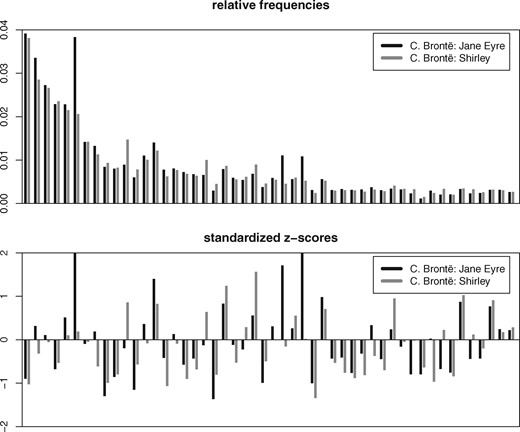


In [ ]:
import math
# mean of the mean frequency of each feature
# exclude testcase from means
authors_no_T = ["H","M", "J", "S", "D"]

# calculate the means of columns. This will be column 8 below
# pandas does this for us
dfFeatures["means"] = dfFeatures[authors_no_T].mean(axis=1)

# calculate stdev of columns compared to sample
# formula stdev = sum(sqrt((x[i] - x[sample])^2/(n - 1)))
# There is a more efficient way of doing this in Pandas but
# (a) I am a newbie
# (b) this makes the process explicit

n = len(authors_no_T)
stdev = list([0]*len(features))

for i in range(len(features)):
  # since we are looping we want to reset some values to 0 each time we restart
  squ_diff_fr_mean = 0
  sum_squ_diff = 0

  author_feature_values = dfFeatures.iloc[[i],[2,3,4,5,6]].values[0]
  feature_mean = dfFeatures.iloc[[i],[8]].values[0]

  for j in range(len(authors_no_T)):
    squ_diff_fr_mean = (author_feature_values[j] - feature_mean[0])**2
    sum_squ_diff = sum_squ_diff + squ_diff_fr_mean
    stdev[i] = math.sqrt(sum_squ_diff/(n - 1))

dfFeatures["stdev"] = stdev


# create a new dataframe to hold z scores
z_cols = list(authors)
z_cols.extend(["means", "stdev"])
dfZ = dfFeatures[z_cols].copy()

#calcuate z-scores
for author in authors:
  dfZ[author] = (dfZ[author] - dfZ["means"])/dfZ["stdev"]
dfZ.head(7)


,H,M,J,S,D,T,means,stdev
0,0.127862,0.563193,-1.737483,0.746945,0.299483,-0.775203,0.090459,0.018570
1,0.866209,0.287422,-1.731761,0.267202,0.310929,-1.830590,0.057670,0.008028
2,1.579048,-0.134646,0.046698,-1.178336,-0.312764,1.022579,0.033011,0.004700
3,-0.841818,-0.297312,1.551652,0.389657,-0.802179,1.018767,0.033125,0.010933
4,1.433679,-0.263251,-1.337926,-0.104915,0.272414,0.597784,0.021299,0.002471
5,0.838040,0.356799,-1.538804,-0.437653,0.781617,-0.919064,0.018039,0.004665
6,0.434220,0.315374,-0.038005,-1.670589,0.959000,1.022857,0.016976,0.007351


Sample values in PH for T (Federalist 64) are:
```
Test case z-score for feature the is -0.7692828380408238
Test case z-score for feature of is -1.8167784558461264
Test case z-score for feature to is 1.032705844508835
Test case z-score for feature and is 1.0268752924746058
Test case z-score for feature in is 0.6085448501260903
Test case z-score for feature a is -0.9341289591084886
Test case z-score for feature be is 1.0279650702511498
```
Our values are close to those calculated there.

## Calculate Burrows's Delta  
> (from PH):  
Finally, calculate a delta score comparing the anonymous paper with each candidate’s subcorpus. To do this, take the average of the ***absolute values of the differences between the z-scores for each feature between the anonymous paper and the candidate’s subcorpus.*** (Read that twice!) This [using the z-score (HL)] gives equal weight to each feature, no matter how often the words occur in the texts; otherwise, the top 3 or 4 features would overwhelm everything else.
  
Taking the ***average*** of these values gives us a single statistic to compare for each author.   

Referring back to the plot of relative frequencies and standardized z-scores we saw earlier, for each of the two novels illustrated, the Burrow's delta of each novel relative to all of Brontë's novels would be the the sum of all the values above and below the line. We take the absolute values (we add all the values as if they were positive), so that highs and lows do not cancel each other out.    

In our case, we are comparing a single document to the average of several corpora to see which our candidate is nearest to.

In [ ]:
# create a new data frame to hold delta
dfDelta = dfZ.copy()
col_keys = list(authors_no_T)
col_vals = list(authors_no_T)
for idx, v in enumerate(col_vals):
  col_vals[idx] = "T_to_" + col_vals[idx]
col_labels = dict(zip(col_keys, col_vals))
dfDelta = dfDelta.rename(index=str, columns=col_labels)

for v in col_vals:
  dfDelta[v] = abs(dfDelta[v] - dfDelta["T"])

# add a row for sums and and delta and calculate

dfDelta.loc["sum"] = dfDelta.sum(axis=0)
dfDelta.loc["delta"] = dfDelta.loc["sum"]/len(features)

# clean up stupid error
all_col_labels = list(dfDelta.columns)
for col in all_col_labels:
  if col not in col_vals:
    dfDelta.loc["sum",col] = ""
    dfDelta.loc["delta", col] = ""

# show the last two lines of our table, with the sum and delta values
dfDelta.tail(2)

,T_to_H,T_to_M,T_to_J,T_to_S,T_to_D,T,means,stdev
sum,53.537958,48.698433,46.525359,55.863225,46.644422,,,
delta,1.784599,1.623281,1.550845,1.862107,1.554814,,,


In [ ]:
# report out

for col in col_vals:
  print("Delta for " + col + " is: ",dfDelta.loc["delta",col])

Delta for T_to_H is:  1.784598596399545
Delta for T_to_M is:  1.6232811058069343
Delta for T_to_J is:  1.5508452839484805
Delta for T_to_S is:  1.8621074873403611
Delta for T_to_D is:  1.5548140546108307


This was the conclusion/outpt in PH
```
Delta score for candidate Hamilton is 1.768470453004334
Delta score for candidate Madison is 1.6089724119682816
**Delta score for candidate Jay is 1.5345768956569326**
Delta score for candidate Disputed is 1.5371768107570636
Delta score for candidate Shared is 1.846113566619675
```

This was Laramée's concluding paragraph:

> As expected, Delta identifies John Jay as Federalist 64’s most likely author. It is interesting to note that, according to Delta, Federalist 64 is more similar to the disputed papers than to those known to have been written by Hamilton or by Madison; why that might be, however, is a question for another day.

Has our work confirmed this?

# Stylometry II: Visualizing Similarity and Difference
Here what we are doing, is essentially repeating what we did when applying Burrow's Delta, with two important changes: (1) we are applying it to each publication separately; and (2) we are comparing every work to every other work to gauge "closeness" or "distance."   
As with topic models or word vector embeddings (see below), we can think of each sample as a vector and use a distance measurement to position them in multidimensional space.
Here there's a problem: how do we examine or visualize these relationships, and how do we find the important ones? (With 30 features, we need to allow up to 29 dimensions to describe the variation. Humans have difficulty imagining more than three.)   
We are going to demo two techniques for visualizing multi-dimensional data: **Principal Component Analysis** (PCA) and **t-distributed stochastic neighbor embedding**.

We will be using the Python library `sklearn` (sci-kit learn, developed for machine learning) to do the hard work for us, and matplotlib to do draw the graphs.

   
## PCA
**Principal Component Analysis** attempts to calculate the directions of the dimensions and their weights. When we are looking at a two dimensional plot of principal components, we are looking at two specific dimensions calculated by the model. The analysis also can tell us how much of the variation among our test cases is explained by the specific components.   
In our case, using the same number of features as before, the first two components account for a little under a quarter of the variation among the documents, but it looks like the first component (the horizontal or x axis) is where a good deal of the author differentiation is happening.

## Prepare the data as for Burrows' Delta
Here we go over the steps that we followed for Burrow's delta to get a frequency table for each individual publication in the Federalist Papers.    
We then reformat the data in a transposed table for PCA. (Without transposing, PCA would calculate how much features differ from one another over the 85D space of the authors. A very different question.)

In [ ]:
# Repeat earlier steps, but now asigning each paper not author to a column
# copy features and corpus data

# repeating here allows us to experiment with feature values
# see the explanations above

corpus_tokens = corpus.split()

# create frequency list using built in nltk function
whole_corpus_freq_dist = list(nltk.FreqDist(corpus_tokens).most_common(30))

# # uncomment and run again to see the check the first 10
# print(whole_corpus_freq_dist[ :10 ])

# data structure to contain our statistical information
dfFeatures_pca = pd.DataFrame( columns=["feats","corpus"])
dfFeatures_pca["feats"] = [w for w, freq in whole_corpus_freq_dist]
dfFeatures_pca["corpus"] = [freq for w, freq in whole_corpus_freq_dist]

# the last time we did this we bundled the docs together by attribution
# This time, we create frequency table by publication rather than author

for p in range(1,len(dfPapers)+1):  # iterate over all the files
  paper_corpus = ' '.join(dfPapers["text"][dfPapers["num"] == p].values)

  #separate into a list of tokens (features)
  paper_tokens = paper_corpus.split()

  paper_length = len(paper_tokens)

  # copy the features to a list
  # for each feature count the proportion of features to total author words
  # append to df

  # create frequency list using built in nltk function
  features = dfFeatures_pca.feats.to_list()

  # calculate proportions
  paper_features = [paper_tokens.count(x)/paper_length for x in features]
  # and add this to the dataframe
  dfFeatures_pca[p] = paper_features


# transpose
dfFeats_transp = dfFeatures_pca.transpose()
dfFeats_transp.drop(["feats", "corpus"],inplace=True)

for f in features:
  dfFeats_transp.rename(columns={features.index(f):f},inplace=True)


# # uncomment to show check data
dfFeats_transp.head()



,the,of,to,and,in,a,be,that,it,is,...,from,their,with,are,on,an,they,states,government,may
1,0.081897,0.065271,0.044335,0.024631,0.016626,0.015394,0.020936,0.017241,0.012315,0.008005,...,0.006773,0.008621,0.003695,0.007389,0.005542,0.006773,0.003695,0.001232,0.005542,0.006773
2,0.064095,0.049258,0.031454,0.049852,0.020178,0.017211,0.008902,0.026113,0.022552,0.009496,...,0.002967,0.012463,0.007715,0.003561,0.004748,0.000593,0.013056,0.001187,0.005341,0.002374
3,0.064846,0.042321,0.038225,0.041638,0.017065,0.008874,0.02116,0.013652,0.014334,0.004778,...,0.010922,0.007509,0.006826,0.005461,0.004096,0.002048,0.003413,0.007509,0.010239,0.004096
4,0.053172,0.043505,0.030816,0.054985,0.014502,0.009668,0.01571,0.010272,0.016918,0.006042,...,0.005438,0.01148,0.007251,0.006647,0.006647,0.001813,0.010272,0.000604,0.009668,0.006042
5,0.049853,0.038856,0.032991,0.053519,0.020528,0.006598,0.022727,0.016862,0.015396,0.005132,...,0.008798,0.008065,0.008065,0.002199,0.003666,0.002933,0.008065,0.000733,0.001466,0.001466


##Calcuate PCA


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
# # # to scale (mean = 0 total stdev = 1)
# # # balances the weights of more or less frequent words
# scaled = StandardScaler().fit_transform(dfFeats_transp)
# principalComponents = pca.fit_transform(scaled)

# to apply scaling uncomment above and comment next line
principalComponents = pca.fit_transform(dfFeats_transp)
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['principal component 1',
                           'principal component 2'])

# add attrib labels
principalDf["attrib"] = dfPapers["attrib"]

principalDf.head()

,principal component 1,principal component 2,attrib
0,0.008809,-0.005929,H
1,0.039816,0.012238,J
2,0.038289,0.009236,J
3,0.053754,0.016098,J
4,0.057351,0.005877,J


## Plot a 2-Dimensional Grid for two Components.
Plot a 2D scatter chart for the two first principal components.  
Federalist 64 is marked in red on the plot. Does this confirm our earlier obsevation using Burrows's Delta?  
This was Laramée's concluding paragraph:
>As expected, Delta identifies John Jay as Federalist 64’s most likely author. It is interesting to note that, according to Delta, Federalist 64 is more similar to the disputed papers than to those known to have been written by Hamilton or by Madison; why that might be, however, is a question for another day.   

Is this still true?  
What happens when we increase the number of features?
Decrease?


[0.3508261  0.13981284]


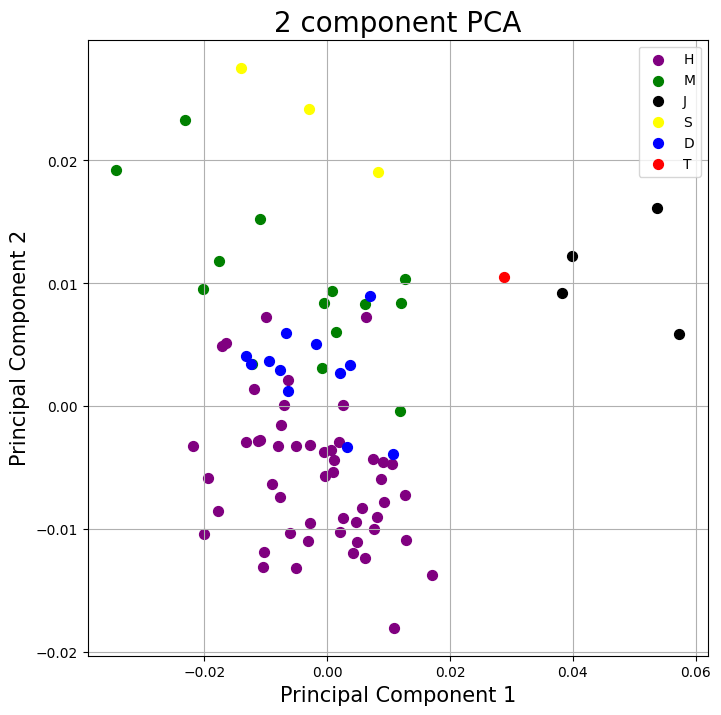

In [ ]:
import matplotlib.pyplot as plt
## plotting code from:
## https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

# print out the amount explained by the first two components
print(pca.explained_variance_ratio_)


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ["H","M","J","S","D","T"]
colors = ['purple', 'green', 'black','yellow', 'blue', 'red']
for target, color in zip(targets,colors):
  indicesToKeep = principalDf['attrib'] == target
  ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1'],
               principalDf.loc[indicesToKeep, 'principal component 2'],
               c = color,
               s = 50)
ax.legend(targets)
ax.grid()


## t-SNE
**t-distributed stochastic neighbor embedding** is another widely used method for visualizing high-dimensional data in 2- to 3-dimensional space.
It assigns a probability that each datapoint is similar to every other datapoint, and then attempts to map those relationships in a lower dimensional space.

A frequent description is that PCA attempts to preserve the overall structure of the data as a whole, while t-SNE preserves the relationship with neighbors.

## Calculating t-SNE
Although the math of the two approaches is different, in scikitlearn, the procedure is more or less the same.

Our data is the same `dFeats_transp` we created for PCA: a table that presents each of the words (features) as columns and each of the documents as rows.

* set the parameters for the t-SNE model we are using

* fit and transform our data to the model to generate an array of points

* plot those points in 2-dimensional space


In [ ]:
# For the code here I have made use of the tutorial at:
# https://github.com/olekscode/Examples-PCA-tSNE/blob/master/Python/Visualizing%20Iris%20Dataset%20using%20PCA%20and%20t-SNE.ipynb

# We set the parameters for t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,
            n_iter=1000,
            random_state=0,
            perplexity=15,
            learning_rate='auto',
            init='random')
points = tsne.fit_transform(dfFeats_transp[features])

In [ ]:
tsneDF = pd.DataFrame(data = points,
                           columns = ['eigenvector 1',
                           'eigenvector 2'])
tsneDF["attrib"] = dfPapers["attrib"]
tsneDF

,eigenvector 1,eigenvector 2,attrib
0,-4.536141,-0.152325,H
1,-11.795347,-7.672694,J
2,-12.213581,-6.000381,J
3,-12.878697,-6.964111,J
4,-13.724689,-7.306799,J
...,...,...,...
80,1.281532,0.562612,H
81,8.693944,0.882086,H
82,-4.147019,2.097744,H
83,-2.913580,-2.236070,H


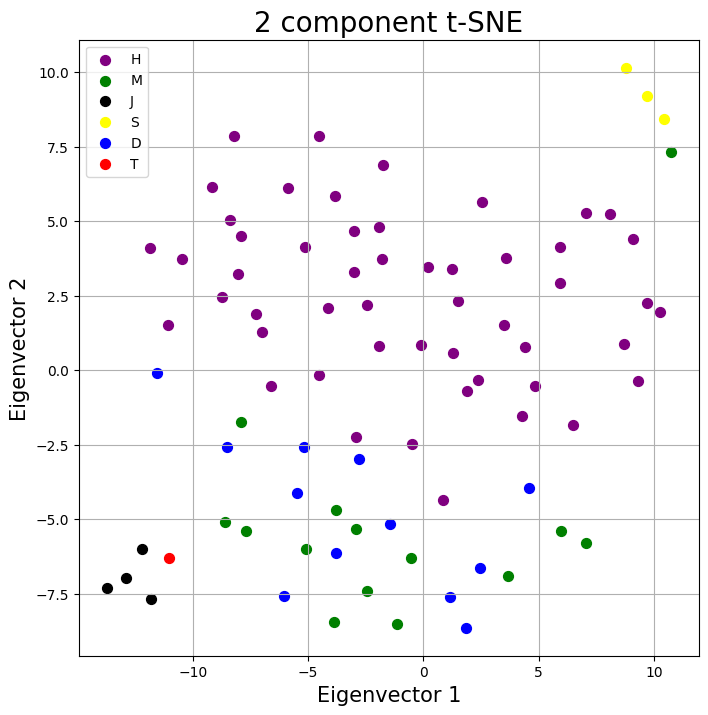

In [ ]:
fig_tsne = plt.figure(figsize = (8,8))
ax = fig_tsne.add_subplot(1,1,1)
ax.set_xlabel('Eigenvector 1', fontsize = 15)
ax.set_ylabel('Eigenvector 2', fontsize = 15)
ax.set_title('2 component t-SNE', fontsize = 20)
targets = ["H","M","J","S","D","T"]
colors = ['purple', 'green', 'black','yellow', 'blue', 'red']
for target, color in zip(targets,colors):
  indicesToKeep = tsneDF['attrib'] == target
  ax.scatter(tsneDF.loc[indicesToKeep, 'eigenvector 1'],
             tsneDF.loc[indicesToKeep, 'eigenvector 2'],
             c = color,
             s = 50)
ax.legend(targets)
ax.grid()

# Semantic extraction: TF-IDF and LDA Topic Modelling

## TF-IDF
In our WordCloud experiment, we have already seen that term-frequency (how often a word appears) may not be the most helpful if we are trying to extract meaning. In that experiment we actively excluded stopwords, really frequent words, in order to get at words that are more indicative of what a text is about. **text frequency-inverse document freqency** (TF-IDF) is a method for weighting the "important" words in a given document.

## Calculting TF-IDF
The intuition behind TF-IDF is pretty straightforward. In the sample of five titles from the Federalist Papers below, the word "the" is very common in general and it appears in every title at least once. This means that it is not likely to be a good indicator of what's in an individual document. However each title also has at least one word (e.g., `'foreign,' 'territory,' 'considered,' 'department,' 'senate'`) that appears in one document only. Most of these (maybe not 'considered', or 'method' in Federalist 49) may point to content.

|index|file name|title|
|---|---|---|
|2|federalist\_3|The Same Subject Continued \(Concerning Dangers From Foreign Force and|
|13|federalist\_14|Objections to the Proposed Constitution From Extent of Territory|
|41|federalist\_42|The Powers Conferred by the Constitution Further Considered|
|48|federalist\_49|Method of Guarding Against the Encroachments of Any One Department of|
|63|federalist\_64|The Powers of the Senate|

In the title to Federalist 2 the **term frequency** of 'the' and 'foreign' are the same: 1 out of 10 or 0.1

**document frequency** refers to the proportion of documents in which the word appears. For 'the' that is 5/5 or 1. For 'foreign' in the title of Federalist 2 the document frequency is 1/5 or 0.2

**In principle**, for any given term in  any given document we get the TF-IDF score by dividing  the term frequency by the document frequency (multiplying it by the inverse of the document frequency). For 'territory' in the title of Federalist 2, TF-IDF is  0, since the term frequency of 'territory' in that text is 0:

>TF-IDF = 0/0.2 = 0

The word  'the' has a TF-IDF of:

>TF-IDF = 0.1/1 = 0.1

For 'foreign':
>TF-IDF = 0.1/0.2 = 0.5

By taking into account the document frequency of 'the' and 'foreign' we count 'foreign' as five times as "important" for this text as 'the.'

**In practice**, TF-IDF uses a formula based on the natural logarithm of the document frequency to calculate the IDF.    
    
The next code block uses Python's `sklearn` library to calculate TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# the n most frequent features (words) across the corpus
# experiment with different values and see the results in the next cell

n = 1000

# set up the constraints for the structure that will
# represent our text as mathematical vectors
tfidf = TfidfVectorizer(
    min_df = 5,             # ONLY select words appearing in more than 5 docs
    max_df = 0.95,          # DO NOT words appearing in >= 95% of docs
    max_features = n,       # the n most frequent words across the corpus
    stop_words = 'english'  # remove very common english words
)

# calculate the tf-idf values for each word in all the documents
# As before, we `fit` and `transform` the data to calculate the TF-IDF values.
# For convenience, here we do this in two separate operations.

# `fit` calculates the df and idf values
# and sets the parameters to create a standardized array
tfidf.fit(dfPapers.text)

TfidfVectorizer(max_df=0.95, max_features=1000, min_df=5, stop_words='english')

In [ ]:
# run this cell to get the first 100 feature names (words)
# based on different values of n in the preceding cell
tfidf.get_feature_names_out()[:100]

array(['able', 'absolute', 'absolutely', 'abuse', 'according',
       'accordingly', 'account', 'act', 'active', 'acts', 'actual', 'add',
       'added', 'addition', 'additional', 'adequate', 'administered',
       'administration', 'admiralty', 'admit', 'admitted', 'adopted',
       'adoption', 'advantage', 'advantages', 'adversaries', 'advice',
       'advocates', 'affairs', 'affect', 'afford', 'agency', 'agreed',
       'aid', 'alarm', 'alterations', 'altogether', 'ambassadors',
       'ambition', 'ambitious', 'america', 'american', 'ancient',
       'annual', 'answer', 'appeal', 'appeals', 'appear', 'appearance',
       'appears', 'applicable', 'applied', 'apply', 'appointed',
       'appointing', 'appointment', 'appointments', 'apprehension',
       'apprehensions', 'apt', 'argument', 'arguments', 'arising',
       'armies', 'arms', 'army', 'article', 'articles', 'arts', 'asked',
       'assemblies', 'assembly', 'assent', 'attachment', 'attempt',
       'attempts', 'attend', 'atte

Create a DataFrame in which every row is a document, and the columns give us the TF-IDF score for each word.

In [ ]:
# transform creates the array of values for each feature for each document
text = tfidf.transform(dfPapers.text)

# sklearn produces a "sparse array," that skips over zero values to save memory
# For Pandas to work with the array we need to convert it to a dense array
# that allows us to address every value by row and column.
dfTFIDF = pd.DataFrame(text.todense())

# get the names of the columns (= words) from our `fitting` operation
dfTFIDF.columns = tfidf.get_feature_names_out()

# view a snapshot of the new dataframe
dfTFIDF

,able,absolute,absolutely,abuse,according,accordingly,account,act,active,acts,...,willing,wisdom,wise,wish,words,work,world,year,years,zeal
0,0.032666,0.000000,0.0,0.000000,0.000000,0.047434,0.000000,0.032666,0.0,0.000000,...,0.000000,0.000000,0.048424,0.000000,0.000000,0.000000,0.044738,0.000000,0.000000,0.139478
1,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.084167,0.134081,0.050132,0.040534,0.000000,0.041292,0.000000,0.000000,0.000000
2,0.056570,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.028285,0.0,0.000000,...,0.043788,0.078961,0.083860,0.047031,0.000000,0.000000,0.038738,0.043788,0.034299,0.000000
3,0.026532,0.063320,0.0,0.000000,0.000000,0.038527,0.000000,0.026532,0.0,0.000000,...,0.041074,0.000000,0.078662,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.045617,0.000000,0.000000,0.000000,0.000000,0.066535,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0.000000,0.011675,0.0,0.000000,0.024526,0.014207,0.052614,0.009784,0.0,0.000000,...,0.000000,0.013656,0.000000,0.000000,0.000000,0.000000,0.000000,0.030293,0.000000,0.000000
81,0.000000,0.000000,0.0,0.000000,0.000000,0.022098,0.000000,0.000000,0.0,0.039479,...,0.000000,0.021241,0.000000,0.000000,0.020459,0.024683,0.000000,0.000000,0.000000,0.000000
82,0.000000,0.000000,0.0,0.008979,0.021808,0.000000,0.007797,0.011600,0.0,0.007523,...,0.000000,0.000000,0.000000,0.000000,0.007797,0.000000,0.000000,0.000000,0.000000,0.000000
83,0.000000,0.000000,0.0,0.020996,0.050998,0.000000,0.054702,0.054251,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.018234,0.043998,0.000000,0.041993,0.000000,0.038607


## Examining Results
What are the ten words with the highest TF-IDF score for each document? (Again, you can experiment with larger or smaller numbers.)    
Impressionistically, how good is the fit between the document titles (an author's or editor's idea of what the work is about) and the TF-IDF keywords?

In [ ]:
n = 10    # the number of key words we want to return

# The Pandas function `nlargest()` applied to each row (`axis=1`)
# gives us the top n words
dfPapers['tfidf_keywords'] = dfTFIDF.apply(lambda x:
                                      ', '.join(x.nlargest(n).index.tolist()),
                                      axis=1)
dfPapers[['num','title','tfidf_keywords']]

,num,title,tfidf_keywords
0,1,General Introduction,"appearance, men, constitution, good, shall, un..."
1,2,Concerning Dangers from Foreign Force and Infl...,"convention, congress, america, union, tried, c..."
2,3,The Same Subject Continued (Concerning Dangers...,"national, causes, nations, war, treaties, just..."
3,4,The Same Subject Continued (Concerning Dangers...,"navigation, militia, nations, war, britain, fl..."
4,5,The Same Subject Continued (Concerning Dangers...,"nations, confederacies, foreign, secure, neigh..."
...,...,...,...
80,81,"The Judiciary Continued, and the Distribution ...","courts, court, supreme, jurisdiction, law, jur..."
81,82,The Judiciary Continued.,"courts, jurisdiction, court, supreme, tribunal..."
82,83,The Judiciary Continued in Relation to Trial b...,"jury, trial, cases, courts, causes, court, cri..."
83,84,Certain General and Miscellaneous Objections t...,"rights, constitution, shall, expense, liberty,..."


## LDA topic modeling
**Topic modeling** means creating a model that describes what topics are in a corpus, how the topics are related to individual texts and to the corpus as a whole.  
**LDA** or Latent Dirichlet Allocation is a very widely used form of topic modeling. Where with TF-IDF we calculated a score for each feature (word) across the documents algebraically, LDA is a probabilistic model. Given a set of documents and a specified number of topics, over many iterations it calculates the probability that a given word belongs with any specific topic and that a given topic belongs with any specific document.

We are using LDA to determine the topics that are operative in our corpus. In practice, we could use the results to cluster our documents by likely topic or assign topics to a previously unseen document.
         
This part of the tutorial has adapted code from: Karsdorp, Folgert, Mike Kestemont, and Allen Riddell. _Data Analysis: Case Studies with Python_. Princeton: Princeton University Press, 2021.
See also: https://www.humanitiesdataanalysis.org/topic-models/notebook.html

## Calculating LDA
We use `sklearn` to do the actual calculating and modeling.   
First, represent the text as a matrix where each row corresponds to a document and each column gives the count of a term in the corpus. (This is analogous to calculating the term frequency for TF-IDF.)    
As with TF-IDF, we can filter out very frequent or infrequent words.

In [ ]:
import sklearn.feature_extraction.text as text

# Use sklearn's feature_extraction module to represent our texts with numerals
# and create a document-term matrix (`dtm`).

# set min_df and max_df; compare above for TF-IDF
# when set as an integer, a count; as a decimal, a proportion
vec = text.CountVectorizer(min_df=5,
                           max_df=0.5,
                           stop_words='english')
dtm = vec.fit_transform(dfPapers['text'])

print(f'Shape of document-term matrix: {dtm.shape}. '
      f'Number of tokens {dtm.sum()}')

Shape of document-term matrix: (85, 2539). Number of tokens 45094


Define a model (with 10 components or "topics") and use `sklearn`'s `LatentDirichletAllocation` class to do the model fitting.

In [ ]:
import sklearn.decomposition as decomposition

# parameter estimation: using sklearn's default estimation method
# in the class LatentDirichletAllocation: variational inference

# DEPENDING ON THE CORPUS SIZE THIS CAN TAKE A WHILE

# define model
model = decomposition.LatentDirichletAllocation(
    n_components=10, learning_method='online', random_state=1)

document_topic_distributions = model.fit_transform(dtm)

In [ ]:
# Get array of "columns" (unique words) in our model
# These should be identical with the terms we extracted above
vocabulary = vec.get_feature_names_out()

In [ ]:
# run this cell to see these column headings
vocabulary

array(['abandon', 'abilities', 'ability', ..., 'yield', 'zeal', 'zealous'],
      dtype=object)

From the model created by `sklearn` extract the topic-word-distributions and the document-topic distributions and store them in two tables (DataFrames). _Topic-word-distributions_ refers to the probabilities that specific words are associated with a given topic; _Document-topic-distributions_ to the probabilities that a certain topic is associated with a given document.

In [ ]:
# For convenience label the topics Topic 1, Topic 2, etc.
# We need to add one to each current topic number for 1 indexing rather than 0.

topic_names = [f'Topic {str(k + 1)}' for k in range(10)]

# save topic word distributions and document topic distributions in separate dfs

# topic word distributions shows how much words are associated with each topic
topic_word_distributions = pd.DataFrame(
    model.components_, columns=vocabulary, index=topic_names)

# document topic distributions shows how much topics
# are associated with each document
document_topic_distributions = pd.DataFrame(
    document_topic_distributions, columns=topic_names, index=dfPapers.index)

# The next cells show what these two dataframes look like

***Topic word distributions:***   
For each topic (row), give the probability of each word (column) being associated with that topic

In [ ]:
topic_word_distributions

,abandon,abilities,ability,able,abolish,abolished,abolition,abridge,abridgment,abroad,...,worse,worthy,writer,writers,wrong,year,years,yield,zeal,zealous
Topic 1,1.105071,0.352700,1.984596,9.983678,2.848709,4.987513,3.462204,3.007321,2.013656,2.008541,...,1.099610,1.159204,1.236375,1.844603,2.898263,7.378455,6.567293,0.619507,2.332099,0.422137
Topic 2,0.644903,0.350469,0.309853,1.324639,0.334522,0.866358,1.474338,0.348132,0.570183,1.782207,...,0.310783,0.373879,0.786044,0.777140,0.305183,0.426310,4.108042,0.327161,0.526154,0.345489
Topic 3,0.320985,0.293244,0.278621,1.298573,0.382682,0.339274,0.331652,0.276765,0.281581,0.361957,...,0.289885,0.494741,0.325634,0.355285,1.845191,0.864915,0.766244,0.350352,2.869654,0.400414
Topic 4,0.256363,0.938141,0.968156,7.199363,1.846114,1.054579,1.015708,0.249096,0.292347,1.423123,...,1.077597,0.327367,0.301400,0.339317,0.252861,0.437442,1.654813,1.794533,2.726711,0.304424
Topic 5,0.282931,0.320694,0.258199,0.523377,0.273233,0.326971,0.280478,0.266185,0.282160,0.343329,...,0.297348,0.346756,0.330715,0.268811,0.301596,0.435517,0.435101,0.319773,0.342347,0.324325
Topic 6,0.291984,0.314630,0.279007,3.638488,0.301313,1.810852,0.311872,0.298884,0.300768,0.274319,...,0.251898,0.325725,0.337902,0.317043,0.297469,1.851694,2.003484,1.107040,0.328915,0.334442
Topic 7,0.389678,2.400177,1.869083,6.043104,1.616637,0.384067,0.397565,1.382963,0.404517,0.299724,...,0.339937,1.684974,1.126403,0.833855,0.328248,3.033480,9.853892,2.176524,6.293486,0.491478
Topic 8,2.176066,3.640346,0.300662,28.886814,2.198806,0.380177,1.342040,1.066766,2.035608,2.136330,...,2.636441,8.471531,2.637642,4.823791,0.577952,12.594879,28.732994,5.811124,7.542843,6.047645
Topic 9,0.980368,0.361358,1.830817,2.854448,2.369949,1.101289,0.285266,0.355964,0.302478,0.280023,...,1.791077,1.355582,1.050218,1.793346,0.393891,2.694974,11.818805,1.120378,0.338968,0.287620
Topic 10,0.310124,0.314335,0.354899,0.454779,0.311406,0.347841,0.339127,0.336685,0.311748,0.294895,...,0.268850,0.318833,0.316391,0.294482,0.325697,0.435031,0.351420,0.327552,0.331068,0.307735


***Document topic distributions:***    
For each document (row), give the probability that any given topic (column) is associated with that document:

In [ ]:
document_topic_distributions

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
0,0.000269,0.000269,0.997580,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269
1,0.000264,0.000264,0.000264,0.000264,0.000264,0.000264,0.000264,0.997625,0.000264,0.000264
2,0.928310,0.000287,0.000287,0.000287,0.000287,0.000287,0.000287,0.069391,0.000287,0.000287
3,0.997493,0.000279,0.000279,0.000279,0.000279,0.000279,0.000279,0.000279,0.000279,0.000279
4,0.000268,0.997587,0.000268,0.000268,0.000268,0.000268,0.000268,0.000268,0.000268,0.000268
...,...,...,...,...,...,...,...,...,...,...
80,0.999075,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103
81,0.997810,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243
82,0.999388,0.000068,0.000068,0.000068,0.000068,0.000068,0.000068,0.000068,0.000068,0.000068
83,0.034048,0.000111,0.000111,0.000111,0.000111,0.000111,0.000111,0.965064,0.000111,0.000111


## Evaluating the results of our LDA model

We can use the document topic distribution table to find the top topics associated with any given document. This example uses  Federalist 12 (row 11; Python starts lists at 0). You can change the number to test other documents.

In [ ]:
doc_num = 11

# unsorted:
print(f'Topics in Federalist {doc_num + 1}')
print(document_topic_distributions.loc[doc_num])

# sorted:
print(f"\nTopics in Federalist {doc_num + 1}, Sorted")
topic_dist_test = document_topic_distributions.loc[doc_num]
topic_dist_test.sort_values(ascending=False)

Topics in Federalist 12
Topic 1     0.066700
Topic 2     0.000184
Topic 3     0.000184
Topic 4     0.931829
Topic 5     0.000184
Topic 6     0.000184
Topic 7     0.000184
Topic 8     0.000184
Topic 9     0.000184
Topic 10    0.000184
Name: 11, dtype: float64

Topics in Federalist 12, Sorted


Topic 4     0.931829
Topic 1     0.066700
Topic 7     0.000184
Topic 8     0.000184
Topic 6     0.000184
Topic 9     0.000184
Topic 2     0.000184
Topic 3     0.000184
Topic 10    0.000184
Topic 5     0.000184
Name: 11, dtype: float64

We can also transpose (`.T`) the table to show how documents are associated with individual topics. This cell extracts the document (by column no.) with the highest probability.

In [ ]:
# documents most strongly associated with each topic
d = document_topic_distributions.T.eq(document_topic_distributions.T.max(
                                      axis=1),axis=0)
d.dot(d.columns)

Topic 1     82
Topic 2     17
Topic 3      0
Topic 4      9
Topic 5     12
Topic 6     41
Topic 7     39
Topic 8     69
Topic 9     77
Topic 10    12
dtype: int64

With the topic word distributions dataframe we created earlier, we can make a table that presents the top `n` words (we are using ten; again, you can experiment) associated with each topic.   
This is usually a more informative way of thinking about our topics than just the numerical label.

In [ ]:
# create df with topic names as index and joined top n words as content
# function to get the top n words sorted
def word_dist_for_topic(topic,n):
    """
    returns the top n words for specified topic
    """
    twd = topic_word_distributions.loc[topic].sort_values(ascending=False).head(n)
    return twd

n = 10 # number of words to return


topics_dict = dict()
for t in topic_names:
    topic_words = word_dist_for_topic(t,n)
    topic_top_words_joined = ", ".join(topic_words.index)
    topics_dict[t]=topic_top_words_joined

topics_df = pd.DataFrame(topics_dict.items(),columns=['topic','topic words'])
topics_df.set_index('topic')

# display topics and most strongly associated topic words
print ("Topics and Topic Words")
topics_df

Topics and Topic Words


,topic,topic words
0,Topic 1,"courts, jurisdiction, causes, court, jury, tri..."
1,Topic 2,"nations, war, cities, confederacy, policy, lea..."
2,Topic 3,"appearance, zeal, arguments, opposition, discu..."
3,Topic 4,"majority, parties, faction, republic, small, c..."
4,Topic 5,"war, nations, executive, representatives, cons..."
5,Topic 6,"commerce, trade, empire, nations, articles, co..."
6,Topic 7,"representatives, congress, executive, confeder..."
7,Topic 8,"senate, representatives, executive, house, pre..."
8,Topic 9,"executive, president, department, judiciary, d..."
9,Topic 10,"trial, jury, law, congress, clause, establishe..."


With these pieces in place, we can create a table that shows, for each document (row), the most strongly associated topic (by label) and the corresponding topic words.


In [ ]:
# idxmax will give us the column with the highest value in each row
df = pd.DataFrame(document_topic_distributions.idxmax(axis=1))

# provide a name for the topic column
df.rename(columns={0: 'topic'},inplace=True)


df['lda_keywords'] = df['topic'].apply(lambda x :
                                 topics_df.loc[topics_df['topic'] == x,
                                'topic words'].item())

# view a snapshot of the table.
df

,topic,lda_keywords
0,Topic 3,"appearance, zeal, arguments, opposition, discu..."
1,Topic 8,"senate, representatives, executive, house, pre..."
2,Topic 1,"courts, jurisdiction, causes, court, jury, tri..."
3,Topic 1,"courts, jurisdiction, causes, court, jury, tri..."
4,Topic 2,"nations, war, cities, confederacy, policy, lea..."
...,...,...
80,Topic 1,"courts, jurisdiction, causes, court, jury, tri..."
81,Topic 1,"courts, jurisdiction, causes, court, jury, tri..."
82,Topic 1,"courts, jurisdiction, causes, court, jury, tri..."
83,Topic 8,"senate, representatives, executive, house, pre..."


## Comparing the results of TF-IDF and LDA
If you've done this tutorial straight through, you can now compare the results of TF-IDF and LDA on each of the Federalist Papers.

In [ ]:
# Comparing TFIDF results and LDA.
dfPapers.join(df)[['num','title','tfidf_keywords','topic','lda_keywords']]

,num,title,tfidf_keywords,topic,lda_keywords
0,1,General Introduction,"appearance, men, constitution, good, shall, un...",Topic 3,"appearance, zeal, arguments, opposition, discu..."
1,2,Concerning Dangers from Foreign Force and Infl...,"convention, congress, america, union, tried, c...",Topic 8,"senate, representatives, executive, house, pre..."
2,3,The Same Subject Continued (Concerning Dangers...,"national, causes, nations, war, treaties, just...",Topic 1,"courts, jurisdiction, causes, court, jury, tri..."
3,4,The Same Subject Continued (Concerning Dangers...,"navigation, militia, nations, war, britain, fl...",Topic 1,"courts, jurisdiction, causes, court, jury, tri..."
4,5,The Same Subject Continued (Concerning Dangers...,"nations, confederacies, foreign, secure, neigh...",Topic 2,"nations, war, cities, confederacy, policy, lea..."
...,...,...,...,...,...
80,81,"The Judiciary Continued, and the Distribution ...","courts, court, supreme, jurisdiction, law, jur...",Topic 1,"courts, jurisdiction, causes, court, jury, tri..."
81,82,The Judiciary Continued.,"courts, jurisdiction, court, supreme, tribunal...",Topic 1,"courts, jurisdiction, causes, court, jury, tri..."
82,83,The Judiciary Continued in Relation to Trial b...,"jury, trial, cases, courts, causes, court, cri...",Topic 1,"courts, jurisdiction, causes, court, jury, tri..."
83,84,Certain General and Miscellaneous Objections t...,"rights, constitution, shall, expense, liberty,...",Topic 8,"senate, representatives, executive, house, pre..."


# A Word About Vector Space
For "Burrow's Delta" we calculated a single statistic for each author that combined our measurements for each feature.    
In our experiments with PCA and t-SNE, we did something else: we represented each document as a ***vector***, a numerical expression with values for each feature.        
TF-IDF is a method for calculating and weighting the values individual features will have.  
In LDA, a "topic" is a vector with values (probabilities) that any of the words in our model is associated with that topic. A "document" is represented as a vector with values across all the topics.   
The number of features that we use dictates the number of dimensions that we need to express our vector in a multi-dimensional space. The mathematics of vectors in multi-dimensional space is central to machine learning and AI methods. A standard task in interpeting results in complex vector space  is to reduce (and reconfigure) the number of dimensions to a number (typically two or three, which humans can imagine in visually) along which the most important differences or similarities can be measured. t-SNE and PCA are methods for doing precisely this. LDA is also effectively a type of dimension reduction, limiting them to the number of topics.  
The Python library [pyLDAvis]('https://pyldavis.readthedocs.io/en/latest/readme.html') provides tools to visualize the results of LDA in two dimensional space.